This Notebook is an adaptation of the [Fastai Lesson 1 notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb) to the [rMASTIF (Croatian) Traffic Sign Classification Dataset](http://www.zemris.fer.hr/~kalfa/Datasets/rMASTIF/) (4044 traffic sign examples in train and 1784 in test set, from 31 classes): 

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need.

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# Classes visualization

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly.

In [4]:
PATH = "D:/Datasets/TrafficSigns/rmastif_fastai/"
sz=299

The loading and visualization code below are adapted from Waleed Abdulla's blog post on [Traffic Sign Recognition with Tensorflow](https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6)

In [5]:
import skimage.transform
import skimage.data
def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) 
                      if f.endswith(".ppm")]
        for f in file_names:
            current_img = skimage.data.imread(f)
            resized_img = skimage.transform.resize(current_img, (32, 32))
            images.append(resized_img)
            labels.append(int(d))
    return images, labels

train_data_dir =  PATH  + 'train/'
test_data_dir = PATH  + 'valid/'
images_test, labels_test = load_data(test_data_dir)

C:\ProgramData\Miniconda3\envs\fastai_env\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


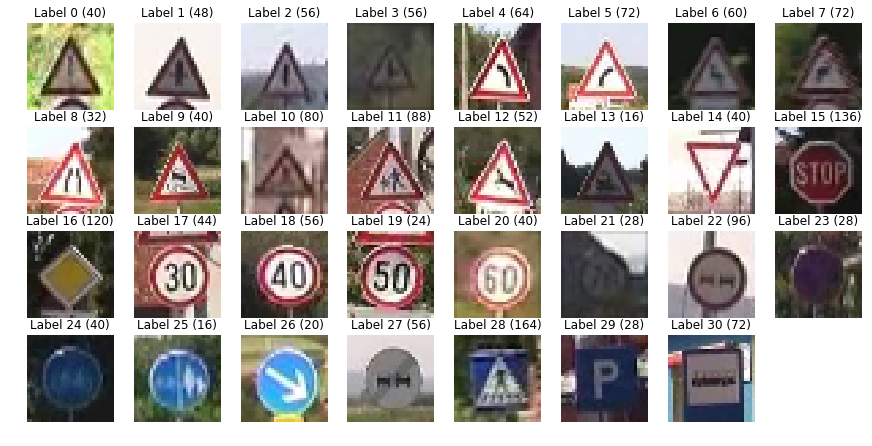

In [6]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images_test, labels_test)

It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed. If you have problems with this, please check the FAQ and ask for help on [the forums](http://forums.fast.ai).

In [7]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [8]:
torch.backends.cudnn.enabled

True

## Define the model

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet50</b> model. resnet50 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). 

In [9]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [10]:
arch=resnet50
bs=32

## Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [11]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_basic, max_zoom=1.3)

In [12]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, num_workers=4)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [13]:
ims = np.stack([get_augs() for i in range(6)])
print(ims.shape)

(6, 299, 299, 3)


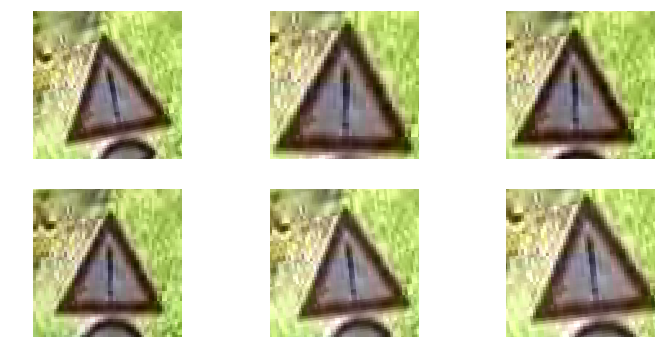

In [14]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms, as well as a ConvLearner object.
Please note that we use a high dropout value, because we're fitting a large model into a small dataset

IMPORTANT NOTE: In this work, the test set is used directly as validation set. In general, one should rather use a validation set different than the test set, so that hyper parameter tuning is done on the validation set, and only the final model is tested on the test set. However, in this case, since the code is mostly taken "out-of-the-box" from fast.ai lesson, and no hyper-parameter tuning has been performed, the results are still legitimate.

In [15]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms,bs=bs)

For now, we set precompute = True, which prevents the data augmentation to have effect, but allows for faster training of the last layers

In [16]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.8) 

## Choosing a learning rate

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [17]:
lrf=learn.lr_find(start_lr=1e-5)

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 107/127 [00:06<00:01, 17.09it/s, loss=20]


Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

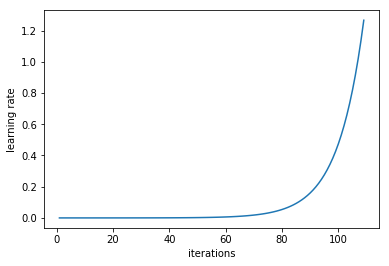

In [18]:
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

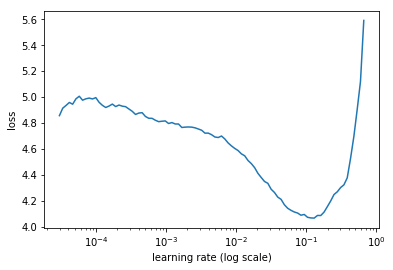

In [19]:
learn.sched.plot()

In [20]:
lr = 1e-1

The loss is still clearly improving at lr=1e-1 (0.1), so that's what we use. Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

## Learning

### Without Data Augmentation (precompute=false)

The [1cycle training policy](https://arxiv.org/abs/1803.09820) is used here, with parameters set according to the experiment 3 provided in Sylvain Gugger's notebook: https://github.com/sgugger/Deep-Learning/blob/master/Cyclical%20LR%20and%20momentums.ipynb

In [21]:
learn.fit(lr, 1, cycle_len=3, use_clr_beta=(20,10,0.95,0.85),wds=1e-4)

epoch      trn_loss   val_loss   accuracy                                                                                                                              
    0      3.101751   1.72132    0.487668  
    1      2.331394   1.544812   0.518498                                                                                                                              
    2      1.913515   1.412511   0.556614                                                                                                                              



[array([1.41251]), 0.5566143497757847]

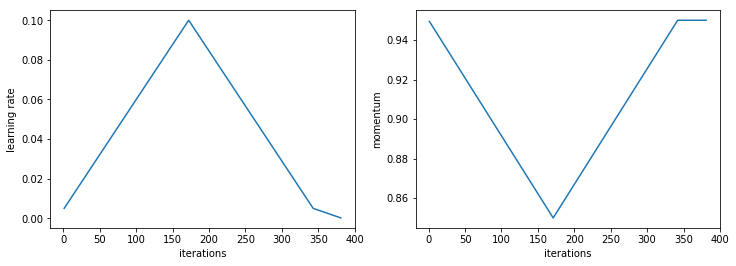

In [22]:
learn.sched.plot_lr()

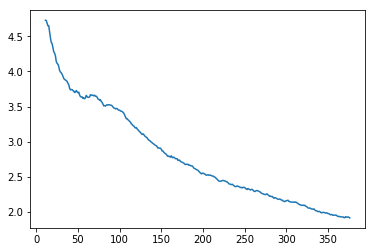

In [23]:
learn.sched.plot_loss()

### Unfreeze all layers

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [24]:
learn.precompute=False

In [25]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*.

In [26]:
lrs=np.array([lr/9,lr/3,lr])

### Use Learning Rate Finder again

In [27]:
learn.lr_find(lrs/1000)

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▋                      | 103/127 [01:12<00:16,  1.43it/s, loss=8.4]

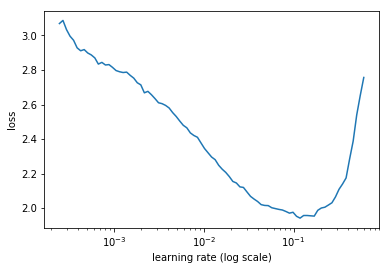

In [28]:
learn.sched.plot()

In [29]:
lr = 5e-2
lrs=np.array([lr/9,lr/3,lr])

### Train again

The [1cycle training policy](https://arxiv.org/abs/1803.09820) is used here again, with the same parameters 

In [30]:
learn.fit(lrs, 1, cycle_len=20, use_clr_beta=(20,10,0.95,0.85), wds=1e-4)

  6%|███████▍                                                                                                               | 8/127 [00:07<01:47,  1.10it/s, loss=2.84]
epoch      trn_loss   val_loss   accuracy                                                                                                                              
    0      1.166117   0.550578   0.806054  
    1      0.532463   0.313255   0.888453                                                                                                                              
    2      0.344137   0.129996   0.963004                                                                                                                              
    3      0.218233   0.078061   0.9787                                                                                                                                
    4      0.136874   0.066175   0.984865                                                                           

[array([0.0346]), 0.9949551569506726]

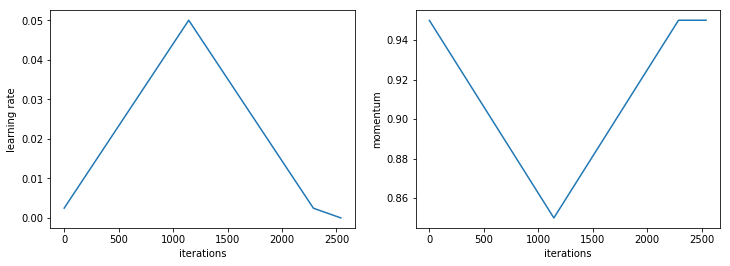

In [31]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

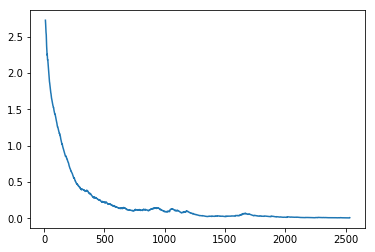

In [32]:
learn.sched.plot_loss()

In [33]:
learn.save('299_all_MASTIF_TSC_3')

In [34]:
learn.load('299_all_MASTIF_TSC_3')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [35]:
log_preds,y = learn.TTA()

In [36]:
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9955156950672646